In [28]:
# extras
import os
import glob
from datetime import datetime, timedelta

# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#widgets
from ipywidgets import interact, widgets, VBox, HBox, Layout

# machine and deep learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Nov.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Dec.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv


In [3]:

cosmetics_event_1_df=pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv')
cosmetics_event_2_df=pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv')
cosmetics_event_10_df=pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv')
cosmetics_event_11_df=pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Nov.csv')
cosmetics_event_12_df=pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Dec.csv')

In [4]:
cosmetics_event_combined_df = pd.concat([
    cosmetics_event_10_df,  
    cosmetics_event_11_df,  
    cosmetics_event_12_df,  
    cosmetics_event_1_df,   
    cosmetics_event_2_df    
], ignore_index=True)

In [5]:
display(cosmetics_event_combined_df.head())
display(cosmetics_event_combined_df.shape) 

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


(20692840, 9)

### dropping user_id, category_id, and user_session since they are irrelevent
### converting event_time using pd.to_datetime()

In [6]:
cols_to_drop = ["user_id", "category_id", "user_session"]
cosmetics_event_combined_df.drop(columns=cols_to_drop, inplace=True)

cosmetics_event_combined_df['event_time'] = pd.to_datetime(cosmetics_event_combined_df['event_time'], errors='coerce')


display(cosmetics_event_combined_df.head())

,event_time,event_type,product_id,category_code,brand,price
0,2019-10-01 00:00:00+00:00,cart,5773203,NaN,runail,2.62
1,2019-10-01 00:00:03+00:00,cart,5773353,NaN,runail,2.62
2,2019-10-01 00:00:07+00:00,cart,5881589,NaN,lovely,13.48
3,2019-10-01 00:00:07+00:00,cart,5723490,NaN,runail,2.62
4,2019-10-01 00:00:15+00:00,cart,5881449,NaN,lovely,0.56


### checking basic info

In [7]:
display(cosmetics_event_combined_df.info())
display(cosmetics_event_combined_df.describe())
display(cosmetics_event_combined_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 6 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_code  object             
 4   brand          object             
 5   price          float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(3)
memory usage: 947.2+ MB


None

,product_id,price
count,2.069284e+07,2.069284e+07
mean,5.484297e+06,8.534735e+00
std,1.305716e+06,1.938142e+01
min,3.752000e+03,-7.937000e+01
25%,5.724650e+06,2.060000e+00
50%,5.810720e+06,4.050000e+00
75%,5.857864e+06,7.060000e+00
max,5.932595e+06,3.277800e+02


event_time              0
event_type              0
product_id              0
category_code    20339246
brand             8757117
price                   0
dtype: int64

### dropping category_code because more than 80 percent is nan 

In [8]:
cosmetics_event_combined_df.drop(columns='category_code', inplace=True)
print(cosmetics_event_combined_df.isna().sum())

event_time          0
event_type          0
product_id          0
brand         8757117
price               0
dtype: int64


### we will leave brand for now and can group the missing in their own category later

### Dividing the time into months year and days to do time based analysis

In [9]:
cosmetics_event_combined_df['year'] = cosmetics_event_combined_df['event_time'].dt.year
cosmetics_event_combined_df['month'] = cosmetics_event_combined_df['event_time'].dt.month
cosmetics_event_combined_df['day'] = cosmetics_event_combined_df['event_time'].dt.day
cosmetics_event_combined_df['hour'] = cosmetics_event_combined_df['event_time'].dt.hour

 ### per month events plot

/tmp/ipykernel_38/2172838338.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cosmetics_event_combined_df['year_month'] = cosmetics_event_combined_df['event_time'].dt.to_period('M')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


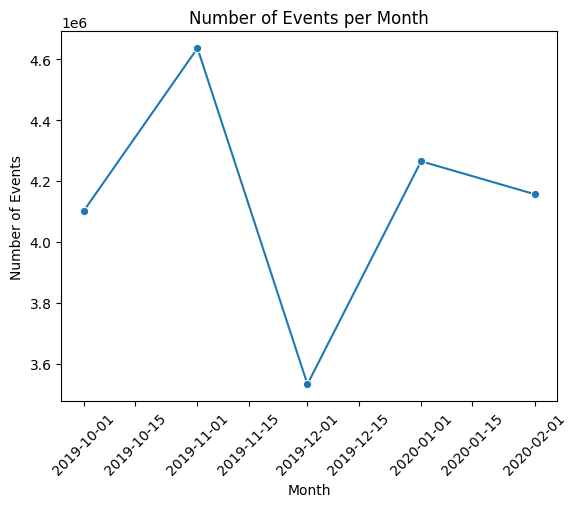

In [10]:
cosmetics_event_combined_df['year_month'] = cosmetics_event_combined_df['event_time'].dt.to_period('M')

monthly_events = cosmetics_event_combined_df.groupby('year_month').size().reset_index(name='count')
monthly_events['year_month'] = monthly_events['year_month'].dt.to_timestamp()

sns.lineplot(data=monthly_events, x='year_month', y='count', marker='o')
plt.title("Number of Events per Month")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.show()


### Hourly events plot

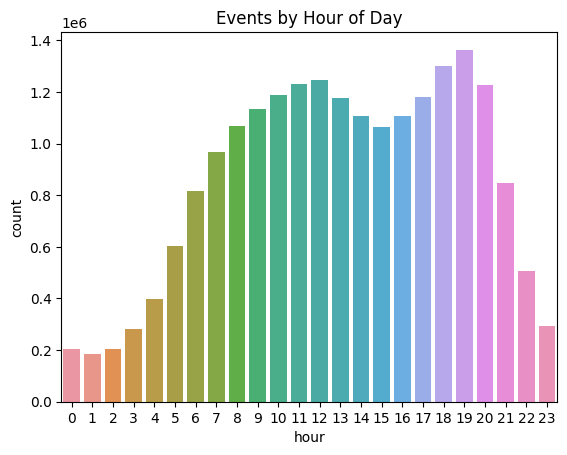

In [11]:
hourly_events = cosmetics_event_combined_df.groupby('hour').size().reset_index(name='count')
sns.barplot(data=hourly_events, x='hour', y='count')
plt.title("Events by Hour of Day")
plt.show()

### event type plot

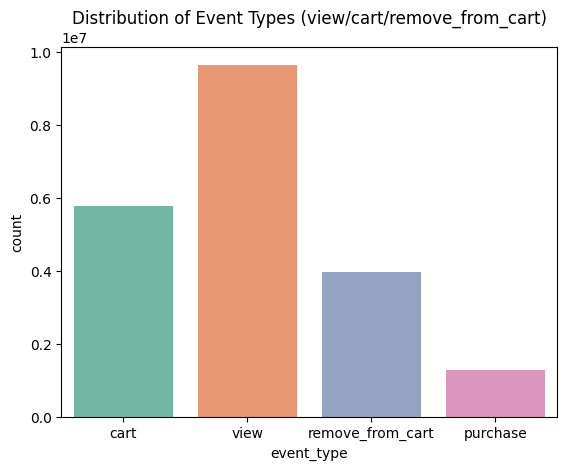

In [12]:
sns.countplot(data=cosmetics_event_combined_df, x='event_type', palette="Set2")
plt.title("Distribution of Event Types (view/cart/remove_from_cart)")
plt.show()

### brand type plot

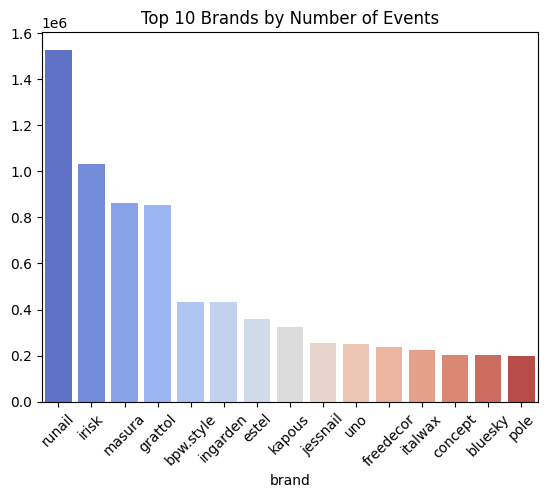

In [13]:
top_brands = cosmetics_event_combined_df['brand'].value_counts().head(15)
sns.barplot(x=top_brands.index, y=top_brands.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Brands by Number of Events")
plt.show()


### price outliers (boxplot & historgam)

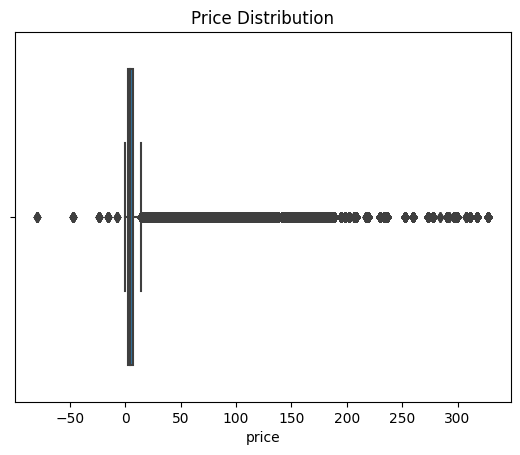

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


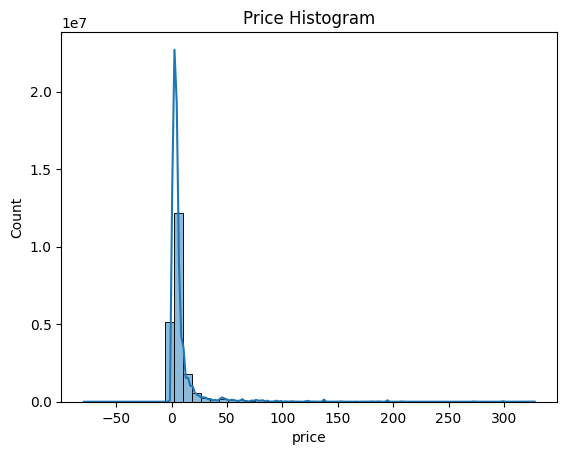

In [14]:
sns.boxplot(x=cosmetics_event_combined_df['price'])
plt.title("Price Distribution")
plt.show()

sns.histplot(cosmetics_event_combined_df['price'], bins=50, kde=True)
plt.title("Price Histogram")
plt.show()

### remove outliers

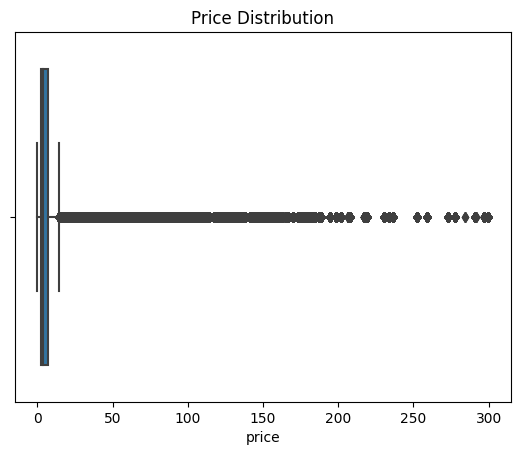

,event_time,event_type,product_id,brand,price,year,month,day,hour,year_month
0,2019-10-01 00:00:00+00:00,cart,5773203,runail,2.62,2019,10,1,0,2019-10
1,2019-10-01 00:00:03+00:00,cart,5773353,runail,2.62,2019,10,1,0,2019-10
2,2019-10-01 00:00:07+00:00,cart,5881589,lovely,13.48,2019,10,1,0,2019-10
3,2019-10-01 00:00:07+00:00,cart,5723490,runail,2.62,2019,10,1,0,2019-10
4,2019-10-01 00:00:15+00:00,cart,5881449,lovely,0.56,2019,10,1,0,2019-10
...,...,...,...,...,...,...,...,...,...,...
20692835,2020-02-29 23:59:32+00:00,view,5885416,grattol,6.27,2020,2,29,23,2020-02
20692836,2020-02-29 23:59:39+00:00,cart,5550686,NaN,1.11,2020,2,29,23,2020-02
20692837,2020-02-29 23:59:45+00:00,view,5850628,grattol,5.24,2020,2,29,23,2020-02
20692838,2020-02-29 23:59:54+00:00,view,5716351,irisk,0.79,2020,2,29,23,2020-02


In [15]:
cosmetics_event_filtered = cosmetics_event_combined_df[(cosmetics_event_combined_df['price'] >= 0) & (cosmetics_event_combined_df['price'] <= 300)]
sns.boxplot(x=cosmetics_event_filtered['price'])
plt.title("Price Distribution")
plt.show()
cosmetics_event_filtered

### correlation between features (numeric cols)

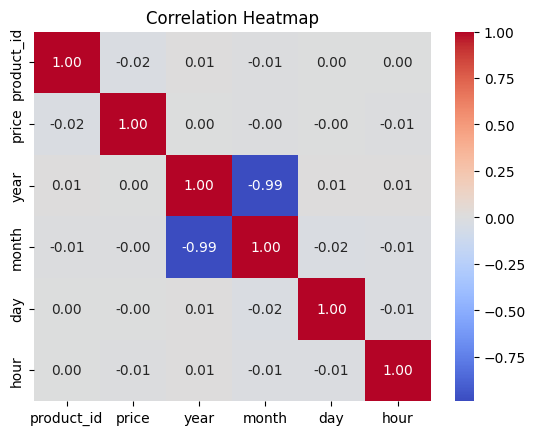

In [16]:
numeric_cols = cosmetics_event_filtered.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# interactive dashboard of the findings

In [ ]:

df = cosmetics_event_filtered.copy()
df["year_month"] = df["year_month"].astype(str)

def show_dashboard(event_types, months, top_n):
    temp = df.copy()
    if event_types:
        temp = temp[temp["event_type"].isin(event_types)]
    if months:
        temp = temp[temp["year_month"].isin(months)]

    monthly = temp.groupby("year_month").size().reset_index(name="count")
    px.line(
        monthly, x="year_month", y="count",
        title=" Monthly Event Counts",
        markers=True,
        color_discrete_sequence=["#2b8cbe"]
    ).show()

    et = temp["event_type"].value_counts().reset_index()
    et.columns = ["event_type", "count"]
    px.bar(
        et, x="event_type", y="count",
        title=" Event Type Distribution",
        color="event_type",
        color_discrete_sequence=px.colors.sequential.Teal
    ).show()

    topb = temp["brand"].value_counts().head(top_n).reset_index()
    topb.columns = ["brand", "count"]
    px.bar(
        topb, x="brand", y="count",
        title=f" Top {top_n} Brands",
        color="count",
        color_continuous_scale=px.colors.sequential.Magma
    ).show()

    hourly = temp.groupby("hour").size().reset_index(name="count")
    px.bar(
        hourly, x="hour", y="count",
        title=" Events by Hour",
        color="count",
        color_continuous_scale=px.colors.sequential.Sunset
    ).show()

event_types_widget = widgets.SelectMultiple(
    options=sorted(df["event_type"].unique()),
    description="Event Types:",
    layout=Layout(width="300px")
)

months_widget = widgets.SelectMultiple(
    options=sorted(df["year_month"].unique()),
    description="Months:",
    layout=Layout(width="300px")
)

top_n_widget = widgets.IntSlider(
    value=15, min=5, max=30, step=5, description="Top N Brands:", style={"description_width": "initial"}
)

ui = VBox([
    HBox([event_types_widget, months_widget]),
    top_n_widget
])

out = widgets.interactive_output(
    show_dashboard,
    {'event_types': event_types_widget, 'months': months_widget, 'top_n': top_n_widget}
)

display(ui, out)


# Now into Machine Learning

In [54]:
cosmetics_event_combined_df['event_time'] = pd.to_datetime(cosmetics_event_combined_df['event_time'])
daily_df = cosmetics_event_combined_df.groupby(['year', 'month', 'day']).size().reset_index(name='sales')
daily_df['date'] = pd.to_datetime(daily_df[['year', 'month', 'day']])
daily_df = daily_df[['date', 'sales']].sort_values('date')


train = daily_df.iloc[:-30]  
test = daily_df.iloc[-30:]

In [55]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)



scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['sales']])
scaled_test = scaler.transform(test[['sales']])


SEQ_LEN = 20  


X_train, y_train = create_sequences(scaled_train, SEQ_LEN)
X_test, y_test = create_sequences(scaled_test, SEQ_LEN)


X_train = X_train.reshape(X_train.shape[0], SEQ_LEN, 1)
X_test = X_test.reshape(X_test.shape[0], SEQ_LEN, 1)

In [56]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )


def forecast_accuracy(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mean_actual = np.mean(y_true)
    return 1 - (mae / mean_actual)


def evaluate_neural_model(model, X_test, y_test, scaler):
    pred = model.predict(X_test)
    pred = pred.reshape(-1, 1)
    pred_inv = scaler.inverse_transform(pred).reshape(-1)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

    mae = mean_absolute_error(y_test_inv, pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
    r2 = r2_score(y_test_inv, pred_inv)
    acc = forecast_accuracy(y_test_inv, pred_inv)
    sm = smape(y_test_inv, pred_inv)

    return mae, rmse, r2, acc, sm

**Prophet**

In [57]:
prophet_df = daily_df.rename(columns={'date': 'ds', 'sales': 'y'})
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='RU')
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

prophet_forecast = forecast['yhat'].tail(30).values
y_test_prophet = test['sales'].values

mae_p = mean_absolute_error(y_test_prophet, prophet_forecast)
rmse_p = np.sqrt(mean_squared_error(y_test_prophet, prophet_forecast))
r2_p = r2_score(y_test_prophet, prophet_forecast)
acc_p = forecast_accuracy(y_test_prophet, prophet_forecast)
smape_p = smape(y_test_prophet, prophet_forecast)

results = {}
results["Prophet"] = [mae_p, rmse_p, r2_p, acc_p, smape_p]

19:56:48 - cmdstanpy - INFO - Chain [1] start processing
19:56:49 - cmdstanpy - INFO - Chain [1] done processing


**DL Models**

In [58]:
dl_models = {
    "LSTM": Sequential([
        LSTM(32, return_sequences=True, input_shape=(SEQ_LEN, 1)),
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ]),
    "BiLSTM": Sequential([
        Bidirectional(LSTM(32, return_sequences=True), input_shape=(SEQ_LEN, 1)),
        Bidirectional(LSTM(16, return_sequences=False)),
        Dropout(0.2),
        Dense(1)
    ]),
    "GRU": Sequential([
        GRU(32, return_sequences=True, input_shape=(SEQ_LEN, 1)),
        GRU(16, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ]),
    "BiGRU": Sequential([
        Bidirectional(GRU(32, return_sequences=True), input_shape=(SEQ_LEN, 1)),
        Bidirectional(GRU(16, return_sequences=False)),
        Dropout(0.2),
        Dense(1)
    ]),
    "CNN": Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=16, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1)
    ]),
    "CNN+BiGRU": Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, 1)),
        MaxPooling1D(pool_size=2),
        Bidirectional(GRU(16, return_sequences=False)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Training and Evaluation Loop**

In [59]:
for name, model in dl_models.items():
    print(f"\n--- Training {name} Model ---")
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(
        X_train, y_train,
        epochs=50,  
        batch_size=4,
        verbose=1
    )
    
    mae, rmse, r2, acc, sm = evaluate_neural_model(model, X_test, y_test, scaler)
    results[name] = [mae, rmse, r2, acc, sm]


--- Training LSTM Model ---
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1059
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0241
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0176
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0230
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

**Comparison Table**

In [60]:
comparison_df = pd.DataFrame.from_dict(results, orient='index', columns=["MAE", "RMSE", "R2", "Accuracy", "SMAPE"])

print("\nComparison of Models")
print(comparison_df)


Comparison of Models
                    MAE          RMSE        R2  Accuracy      SMAPE
Prophet    13998.197745  17013.616635 -0.198544  0.902093   9.958045
LSTM       14065.436719  16822.432644 -0.238675  0.895813  10.549101
BiLSTM     17368.081250  21043.734512 -0.938319  0.871350  13.217077
GRU        11660.562500  14269.601820  0.108742  0.913627   8.754305
BiGRU      12151.785938  14690.525328  0.055386  0.909988   9.147975
CNN        11676.583594  13643.227403  0.185270  0.913508   8.786597
CNN+BiGRU  10585.884375  12626.688944  0.302156  0.921587   7.984658
